__<span style="background-color: yellow">Note:</span> This is an updated version of [the original notebook](https://github.com/BuzzFeedNews/2021-09-guardianship-filings/blob/00e55ac3cf718f020f63cf2209ec7b5260a3d240/notebooks/analyze-filing-counts.ipynb), incorporating two additional states that provided or clarified data after the initial publication of the analysis. For more details [see here](https://github.com/BuzzFeedNews/2021-09-guardianship-filings/tree/updates). This update keeps the methodology and code the same as the original, but adjusts the phrasing of some numbers (for instance, the number of states analyzed) where appropriate.__


# Estimating the national rate of guardianship filings

This notebook attempts to estimate the number of guardianship cases filed annually, using data BuzzFeed News requested from all 50 US states and the District of Columbia. Data was not available from all states, and other states' data proved to be unusable, so we explore various approaches to extrapolating the national number from a limited sample. Please see this repository's landing page and/or `README.md` document for important details and methodological context.

In [1]:
import pandas as pd
import numpy as np
import random
from us import states
import statsmodels.api as sm
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()
seed=sum(map(ord, "BuzzFeed News"))
random.seed(seed)
np.random.seed(seed)

# Load the guardianship data

Here we load the guardianship filing counts we collected, for all years and disaggregated into several categories. See the `README.md` document for variable definitions.

In [2]:
counts = pd.read_csv("../data/raw/filing-counts.csv")
counts.head()

,state,year,case_action,case_type,age_group,count,for_total
0,Alaska,2020,Ambiguous,G+C+Joint,Adults+Minors,1171,Y
1,Alaska,2019,Ambiguous,G+C+Joint,Adults+Minors,1084,Y
2,Alaska,2018,Ambiguous,G+C+Joint,Adults+Minors,1227,Y
3,Alaska,2017,Ambiguous,G+C+Joint,Adults+Minors,1090,Y
4,Arizona,2020,Ambiguous,Guardianship ONLY,Adults ONLY,2520,Y


In [3]:
len(counts)

384

In [4]:
counts["state"].nunique()

38

Although we've collected data from most states, only 25 jurisdictions (24 states plus the District of Columbia) have data fully usable for generating annual totals of *adult* guardianship filings. See the `README.md` document for more details.

In [5]:
(
    counts
    .loc[lambda df: df["for_total"] == "Y"]
    .loc[lambda df: df["age_group"] == "Adults ONLY"]
    ["state"]
    .nunique()
)

25

# Examine years available

All usable jurisdictions have data for 2019, and all but one for 2018. (And although we have collected data for 2020 for many states, we will generally ignore it due to the likelihood that the COVID-19 pandemic affected filing rates.)

In [6]:
(
    counts
    .loc[lambda df: df["for_total"] == "Y"]
    .loc[lambda df: df["age_group"] == "Adults ONLY"]
    .groupby(["year"])
    ["state"]
    .nunique()
    .sort_index()
)

year
2016     8
2017    16
2018    24
2019    25
2020    21
Name: state, dtype: int64

Here we identify the latest year of usable data available for each jurisdiction. In this case, all values are `2019`, but the approach implemented in this code allows for flexibility when/if the data changes.

In [7]:
states_latest_year = (
    counts
    .loc[lambda df: df["for_total"] == "Y"]
    .loc[lambda df: df["age_group"] == "Adults ONLY"]
    .loc[lambda df: df["year"] < 2020]
    .groupby(["state"])
    ["year"].max()
    .to_frame("year_max")
    .reset_index()
)

states_latest_year

,state,year_max
0,Arizona,2019
1,Arkansas,2019
2,Colorado,2019
3,Connecticut,2019
4,District of Columbia,2019
5,Idaho,2019
6,Kansas,2019
7,Kentucky,2019
8,Massachusetts,2019
9,Michigan,2019


In [8]:
states_latest_year["year_max"].value_counts()

2019    25
Name: year_max, dtype: int64

Using the table above, we select *just* the counts belonging to each jurisdiction's most recent year:

In [9]:
latest = (
    counts
    .pipe(lambda df: (
        df
        .merge(
            states_latest_year,
            how = "left",
            on = "state",
        )
    ))
    .loc[lambda df: df["year"] == df["year_max"]]
    .drop(columns = ["year_max"])
)

latest.head()

,state,year,case_action,case_type,age_group,count,for_total
8,Arizona,2019,Ambiguous,Guardianship ONLY,Adults ONLY,2383,Y
9,Arizona,2019,Ambiguous,Guardianship ONLY,Minors ONLY,3608,N
10,Arizona,2019,Ambiguous,Conservatorship ONLY,Adults ONLY,4003,N
11,Arizona,2019,Ambiguous,Conservatorship ONLY,Minors ONLY,1334,N
19,Arkansas,2019,Ambiguous,G+C+Joint,Adults ONLY,1164,Y


In [10]:
latest.to_csv("../data/processed/latest-counts.csv", index=False)

# Load population data

In order to get per-capita rates, we'll need popuation data. Here we use the [Census Population Estimates Program's estimates for 2019](https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.xlsx), overall and for age 18+:

In [11]:
populations = (
    pd.read_excel(
        "../data/raw/census-populations-2019.xlsx",
        header=None,
        skiprows=9,
        skipfooter=7,
        names = [ "state", "pop_total", "pop_adult", "pct" ],
        dtype = {
            "pop_total": int,
            "pop_adult": int,
        }
    )
    .drop(columns = [ "pct" ])
    .assign(
        state = lambda df: df["state"].str.replace(r"^\.", "", regex=True),
    )
)

populations.head(10)

,state,pop_total,pop_adult
0,Alabama,4903185,3814879
1,Alaska,731545,551562
2,Arizona,7278717,5638481
3,Arkansas,3017804,2317649
4,California,39512223,30617582
5,Colorado,5758736,4499217
6,Connecticut,3565287,2837847
7,Delaware,973764,770192
8,District of Columbia,705749,577581
9,Florida,21477737,17247808


In [12]:
len(populations)

51

In [13]:
# Check that our state names match the Census's
assert len(set(counts["state"]) - set(populations["state"])) == 0

# Total the total-able data, and calculate per capita rates

We merge the adult populations with the case count data and, for each jurisdiction and year, sum all `count`s where `for_total` is `"Y"` and `age_group` is `Adults ONLY`. Then we calculate the rate of filings per 100,000 adult residents.

In [14]:
def get_totals_and_rates(subset):
    return (
        subset
        .groupby(["state", "year"])
        ["count"]
        .sum()
        .to_frame("total")
        .reset_index()
        .merge(
            populations
            [[
                "state",
                "pop_adult",
            ]],
            how = "left",
            on = "state"
        )
        .assign(
            per_100k = lambda df: df["total"] / (df["pop_adult"] / 1e5)
        )
    )

In [15]:
latest_totals = get_totals_and_rates(
    latest
    .loc[lambda df: df["for_total"] == "Y"]
    .loc[lambda df: df["age_group"] == "Adults ONLY"]
)

latest_totals.sort_values("per_100k", ascending=False)

,state,year,total,pop_adult,per_100k
3,Connecticut,2019,4700,2837847,165.618513
9,Michigan,2019,12655,7842924,161.355637
12,Nebraska,2019,2109,1458334,144.617077
21,Vermont,2019,512,509984,100.395307
4,District of Columbia,2019,575,577581,99.553136
13,New Hampshire,2019,945,1104458,85.562330
17,Ohio,2019,6991,9111081,76.730741
8,Massachusetts,2019,4059,5539703,73.271076
24,West Virginia,2019,894,1432580,62.404892
11,Missouri,2019,2922,4766843,61.298432


In [16]:
len(latest_totals)

25

How many filings do these jurisdictions account for?:

In [17]:
known_total = latest_totals["total"].sum()
print(known_total)

62249


What proportion of the full adult population (of the 50 states and DC) do these jurisdictions account for?:

In [18]:
(
    (
        populations
        .loc[lambda df: df["state"].isin(latest_totals["state"])]
        ["pop_adult"]
        .sum() / populations["pop_adult"].sum()
    ) 
    .round(3)   
)

0.378

And here we isolate the states for which we don't have usable totals:

In [19]:
not_counted = (
    populations
    .loc[~populations["state"].isin(latest_totals["state"])]
)

len(not_counted)

26

# Examine the distribution of per capita filing rates

To get an overview of our data, we examine some basic metrics (mean, median, range, standard deviation) of the filing rates:

In [20]:
(
    latest_totals
    ["per_100k"]
    .describe()
)

count     25.000000
mean      67.713067
std       38.799605
min       31.494369
25%       42.936697
50%       51.602665
75%       76.730741
max      165.618513
Name: per_100k, dtype: float64

... and create a histogram of the distribution:

In [21]:
bin_width = 40
bin_max = 250
bin_count = int(bin_max / bin_width)
bins = np.arange(0, bin_max, bin_width)

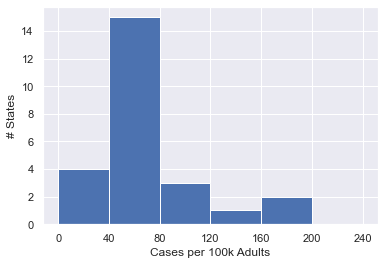

In [22]:
ax = (
    latest_totals
    ["per_100k"]
    .hist(bins=bins)
)
plt.xticks(bins)
ax.set_xlabel("Cases per 100k Adults")
ax.set_ylabel("# States")
pass

# Generating simple national estimates

A simple approach to estimating the number of cases filed nationally in 2019 would be to multiply the *overall* filing rate per capita in the jurisdictions for which we have totals and to multiply it by the total adult population in all 50 states and DC (shortened below to the "total US adult population," although please note that this number excludes US territories):

In [23]:
round(
    (latest_totals["total"].sum() / latest_totals["pop_adult"].sum()) * 
    populations["pop_adult"].sum() 
)

164526

Alternatively, but in the same vein, we could apply the *average state filing rate* to the total US adult population — an approach that mirrors [the methodology applied](https://www.eldersandcourts.org/__data/assets/pdf_file/0021/5844/ovc-brief-7.pdf) (see p. 4) by the National Center for State Courts to a survey of 2015 adult guardianship/conservatorship filings in 16 states, which resulted in a nearly identical figure ("an estimated 180,000," [elsewhere summarized](http://web.archive.org/web/20170906012840/https://www.ncsc.org/Newsroom/Backgrounder/2016/Guardianship.aspx) as "176,000"):

In [24]:
round(
    (latest_totals["per_100k"].mean() * populations["pop_adult"].sum() / 1e5))

172804

... or apply that average rate *only to the remaining states*, which reduces the estimate slightly:

In [25]:
round(
    (latest_totals["per_100k"].mean() * not_counted["pop_adult"].sum() / 1e5)
    + known_total
)

169672

These approaches may provide useful ballpark estimates but they also have some key disadvantages — mainly that they produce only single-number estimates, with no sense of how widely the range of actual possibilities may be.

The first approach also gives more weight to the larger states we have observed, because they account for more of the population in the sample.

# Bootstrapping a national estimate

Another approach we can take, to incorporate the uncertainty involved in the extrapolations, is to "bootstrap" a distribution of estimates for the remaining states. This method hypothetically assigns each of those states to one of the per capita filing rates we have observed (selected at random), calculates what the total would be for each of those state-rate combinations, and then sums up the total. Finally, we add each hypothetical's total for the those states to our known total.

In [26]:
def gen_random_items(pool, n):
    return [ random.choice(list(pool)) for _ in range(n) ]

def gen_random_estimate(populations, rates):
    rand_rates = gen_random_items(rates, len(populations))
    return (populations * rand_rates).sum()

def bootstrap(populations, rates, n=1e4):
    return pd.Series(gen_random_estimate(populations, rates) for _ in range(int(n)))

def describe(series):
    return (
        series
        .describe(percentiles=[0.025, 0.25, 0.5, 0.75, 0.975])
        .astype(int)
    )

def hist(series):
    return (
        series
        .hist(
            bins=np.arange(1e5, 3.1e5, int(1e4)),
            alpha=0.5
        )
    )

Basic statistics about the resulting range of estimates:

In [27]:
bootstrapped_not_counted = bootstrap(
    not_counted["pop_adult"] / 1e5,
    latest_totals["per_100k"],
    n = 1e4
)

describe(bootstrapped_not_counted + known_total)

count     10000
mean     169894
std       18192
min      130881
2.5%     141745
25%      156176
50%      167242
75%      181235
97.5%    211340
max      255332
dtype: int64

... and a histogram of of them:

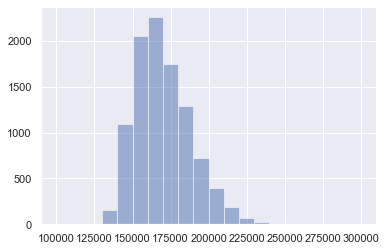

In [28]:
hist(bootstrapped_not_counted + known_total);

# Modeling the counts through the negative binomial distribution

The data collected represents a finite number of observations. If we had infinitely many states' of data, what might this distribution look like? We can "model" this by fitting the observed data to a statistical distribution that aligns — conceptually and empirically — with what we've seen.

A reasonable candidate is the [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution), which statisticians often use to model count-based metrics and which in this case appears to match our observations reasonably well. Below we estimate the parameters for our negative binomial distribution, based on our *observed* per capita rates' mean and variance, and overlay it on our observed distribution in two ways:

- A smooth line representing the negative binomial's [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)

- A histogram representing 10,000 hypothetical observations randomly generated from the negative binomial

In [29]:
def calculate_nbinom_np(rates):
    mean = rates.mean()
    variance = rates.var()
    n = pow(mean, 2) / (variance - mean)
    p = mean / variance
    return n, p

def nbinom_from_rates(rates):
    return nbinom(*calculate_nbinom_np(rates))

In [30]:
nbinom_dist = nbinom_from_rates(latest_totals["per_100k"])

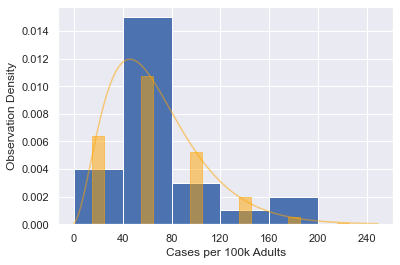

In [31]:
_x = np.arange(0, bin_max)

ax = (
    latest_totals
    ["per_100k"]
    .hist(bins=bins, density=True)
)
plt.xticks(bins)
ax.set_xlabel("Cases per 100k Adults")
ax.set_ylabel("Observation Density")

ax.hist(
    nbinom_dist.rvs(size=10000),
    bins=bins,
    density=True,
    alpha=0.5,
    rwidth=0.25,
    align="mid",
    edgecolor="orange",
    color="orange",
)

ax.plot(_x, nbinom_dist.pmf(_x), color="orange", alpha=0.5)
pass

The fit isn't *perfect*, and with our relatively small sample size we wouldn't expect it to be. But it appears to represent our data fairly well.

# Using the negative binomial distribution for a Monte Carlo simulation

One motivation for modeling the data with a negative binomial distribution is so that we can use it to generate a set of estimates using the "Monte Carlo" method — an approach similar to bootstrapping. Unlike the bootstrap method above, where we randomly select per capita filing rates from our pool of observations, we now randomly select them from our negative binomial distribution.

In [32]:
def gen_random_estimate_mc(populations, dist):
    rand_rates = dist.rvs(size=len(populations))
    return (populations * rand_rates).sum()

def monte_carlo(populations, dist, n=1e4):
    return pd.Series(gen_random_estimate_mc(populations, dist) for _ in range(int(n)))

In [33]:
mc_nbinom_not_counted = monte_carlo(
    not_counted["pop_adult"] / 1e5,
    nbinom_dist,
    n = 1e4
)

pd.DataFrame({
    "Bootstrap": describe(bootstrapped_not_counted + known_total),
    "Monte Carlo": describe(mc_nbinom_not_counted + known_total),
})

,Bootstrap,Monte Carlo
count,10000,10000
mean,169894,169664
std,18192,18666
min,130881,117724
2.5%,141745,137049
25%,156176,156575
50%,167242,168027
75%,181235,181087
97.5%,211340,209963
max,255332,258759


Although the assumptions here are slightly different than for the bootstrap, and allow for a greater range of rates, the resulting estimates end up remarkable similar. Here are histograms of the two results, with the bootstrap in blue and the Monte Carlo simulation in orange:

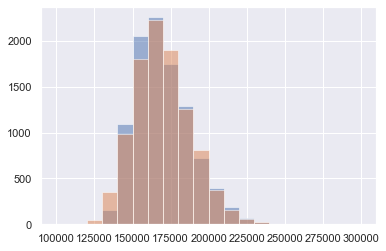

In [34]:
hist(bootstrapped_not_counted + known_total)
hist(mc_nbinom_not_counted + known_total);

# Incorporating data from states that do not disambiguate adults/minors

Although we don't have fully-usable data from states that do not disambiguate between guardianships of adults and those of minors, we can still use this information to construct some bounds. There cannot be, for instance, more adult guardianship filings in these states than there are total adult+minor filings combined. And adult guardianship filings are likely to be some substantial portion of those filings. Although that portion is unknown, in states that do disambiguate those two types of cases the adult proportion appears to typically be between 50% and 95% of the total. Below, we generate a series of estimates that combine the following totals:

- The known totals in our 25 disambiguated jurisdictions
- The `Adults+Minors` totals for the states that provide them, multiplied by 0.5, 0.6, 0.7, 0.8, or 0.9
- The results of a Monte Carlo simulation, using the same negative binomial distribution as above, for the remaining states

This gives us a sense of the potential outcomes, given a range of adult:total ratios for the `Adults+Minors` states. Because we are multiplying all states by the same adult:total ratio, the distributions of each set of results is artificially narrow, but they provide a further sense of the possible national totals.

In [35]:
latest_totals_all_ages = get_totals_and_rates(
    counts
    .loc[lambda df: df["year"] == 2019]
    .loc[lambda df: df["for_total"] == "Y"]
    .loc[lambda df: df["age_group"] == "Adults+Minors"]
)

assert latest_totals_all_ages["state"].isin(latest_totals["state"]).sum() == 0

print(f"{len(latest_totals_all_ages)} states with Adults+Minors counts")
latest_totals_all_ages

12 states with Adults+Minors counts


,state,year,total,pop_adult,per_100k
0,Alaska,2019,1084,551562,196.532756
1,California,2019,16634,30617582,54.328261
2,Delaware,2019,1744,770192,226.437044
3,Florida,2019,7906,17247808,45.837709
4,Hawaii,2019,613,1116004,54.928119
5,Indiana,2019,8301,5164245,160.739856
6,Montana,2019,1129,840190,134.374368
7,Nevada,2019,2513,2387517,105.255795
8,New York,2019,26763,15425262,173.501105
9,North Carolina,2019,4649,8187369,56.782588


In [36]:
mc_nbinom_no_data = monte_carlo(
    (
        populations
        .loc[lambda df: ~df["state"].isin(latest_totals["state"])]
        .loc[lambda df: ~df["state"].isin(latest_totals_all_ages["state"])]
        ["pop_adult"]
    ) / 1e5,
    nbinom_dist,
    n = 1e4
)

In [37]:
pd.DataFrame({
    f"{x*100:.0f}%": describe(mc_nbinom_no_data + known_total + latest_totals_all_ages["total"].sum() * x) 
    for x in np.arange(0.5, 1, 0.1)
})

,50%,60%,70%,80%,90%
count,10000,10000,10000,10000,10000
mean,148017,156131,164245,172359,180473
std,10405,10405,10405,10405,10405
min,120576,128690,136804,144918,153032
2.5%,131015,139129,147243,155357,163471
25%,140479,148593,156707,164821,172935
50%,146878,154993,163107,171221,179335
75%,154153,162267,170381,178495,186609
97.5%,171526,179640,187754,195868,203982
max,201414,209528,217642,225756,233870


# Examining prior years

Although our data is most complete from 2019, which is also the most recent pre-pandemic year, we might be intersted to see how the rates have has changed from prior years. To do so, we calculate the negative binomial distribution for 2017 and 2018 and compare it to 2019. Such comparisons should be taken lightly, since the sample is different for each year, but they seem to indicate that filing rates have likely increased during this time: 

In [38]:
nbinom_dist_years = pd.Series({ year:(
    nbinom_from_rates(
        get_totals_and_rates(
            counts
            .loc[lambda df: df["year"] == year]
            .loc[lambda df: df["for_total"] == "Y"]
            .loc[lambda df: df["age_group"] == "Adults ONLY"]
        )
        ["per_100k"]
    )
) for year in [ 2017, 2018, 2019 ]})

In [39]:
nbinom_dist_years.apply(lambda dist: dist.mean()).round(1)

2017    56.8
2018    62.6
2019    67.7
dtype: float64

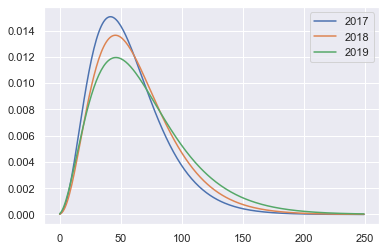

In [40]:
nbinom_pmf_years = nbinom_dist_years.apply(lambda dist: pd.Series(dist.pmf(_x))).T
nbinom_pmf_years.loc[:,:2019].plot();

Another, more direct way of looking at this is to compare filing rates in both 2018 and 2019 for the jurisdictions where we have both counts. Here, we see a slight increase in the majority of jurisdictions and overall:

In [41]:
change_2018_19 = (
    get_totals_and_rates(
        counts
        .loc[lambda df: df["for_total"] == "Y"]
        .loc[lambda df: df["age_group"] == "Adults ONLY"]        
    )
    .loc[lambda df: df["year"].isin([ 2018, 2019 ])]
    .set_index([
        "state",
        "year"
    ])
    ["per_100k"]
    .unstack()
    .dropna()
    .assign(
        change = lambda df: df[2019] - df[2018]
    )
)

change_2018_19.sort_values("change", ascending=False).round(2)

year,2018,2019,change
state,,,
Kentucky,35.62,43.09,7.48
Nebraska,138.31,144.62,6.31
West Virginia,57.66,62.40,4.75
Vermont,96.67,100.40,3.73
Utah,32.49,36.18,3.69
Washington,47.06,50.19,3.13
Kansas,49.07,51.60,2.53
Ohio,74.22,76.73,2.51
New Mexico,40.96,42.94,1.97


In [42]:
change_2018_19["change"].describe()

count    24.000000
mean      1.077307
std       3.277044
min      -7.395609
25%       0.439312
50%       0.794413
75%       2.679093
max       7.475175
Name: change, dtype: float64

# Appendix A: Adjusting for population size

Our sample of jurisdictions for which we have fully usable data spans a broad range of populations, but slightly overrepresents smaller states and slightly underrepresents larger states. We can this see by grouping all jurisdictions into three population terciles and comparing the size-distribution in and out of our sample:

In [43]:
(
    populations
    .assign(
        in_sample = lambda df: df["state"].isin(latest_totals["state"]),
        pop_adult_tercile = lambda df: pd.qcut(df["pop_adult"], 3),
    )
    .groupby("in_sample")
    ["pop_adult_tercile"]
    .value_counts(normalize=True)
    .unstack()
    .T
    .round(2)
)

in_sample,False,True
"(445024.999, 2254204.0]",0.31,0.36
"(2254204.0, 4899310.333]",0.35,0.32
"(4899310.333, 30617582.0]",0.35,0.32


We also observe a *potential* negative correlation between population size and filings per capita:

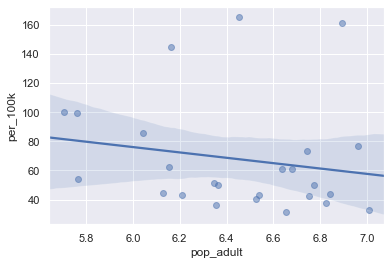

In [44]:
(
    latest_totals
    .pipe(lambda df: sns.regplot(
        x = df["pop_adult"].apply(np.log10),
        y = df["per_100k"],
        truncate = False,
        scatter_kws = { "alpha": 0.5 }
    ))
)
pass

The relationship does not reach standard levels of statistical significance, although our observations may be underpowered (i.e., sample size too small) to reach that level:

In [45]:
pop_ols = (
    latest_totals
    .pipe(lambda df: (
        sm.OLS(
            df["per_100k"],
            sm.add_constant(df["pop_adult"].apply(np.log10)),
        )
     ))
    .fit()
)

pop_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               per_100k   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7838
Date:                Thu, 30 Sep 2021   Prob (F-statistic):              0.385
Time:                        10:01:07   Log-Likelihood:                -126.00
No. Observations:                  25   AIC:                             256.0
Df Residuals:                      23   BIC:                             258.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.6542    134.573      1.387      0.179     -91.730     465.039
pop_adult    -18.4366     20.825     -0.885      0.385     -61.516      24.642
==============================================================================
Omnibus:                       14.990   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.601
Skew:                           1.653   Prob(JB):                     0.000675
Kurtosis:                       4.758   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's unclear whether the relationship is causal, or whether it even holds across the full set of states. But to test the sensitivity our estimates to such a possible influence, we can repeat our bootstrap approach while adjusting for population size.

We'll use the observed correlation above; it is somewhat arbitrary, but should serve as a useful demonstration.

We calculate the adjustment in this manner: `coef * (log10(state's adult population) - log10(average state adult population))`, where `coef` is the coefficient for `log10(adult_pop)` in the regression above.

In [46]:
adjustment_table = (
    populations
    .assign(
        pop_adult_log10 = lambda df: df["pop_adult"].apply(np.log10),
        adj = lambda df: (
            pop_ols.params["pop_adult"] * 
            (df["pop_adult_log10"] - df["pop_adult_log10"].mean())
        )
    )
)

adjustment_table.head()

,state,pop_total,pop_adult,pop_adult_log10,adj
0,Alabama,4903185,3814879,6.581481,-1.864585
1,Alaska,731545,551562,5.741594,13.620104
2,Arizona,7278717,5638481,6.751162,-4.992940
3,Arkansas,3017804,2317649,6.365048,2.125716
4,California,39512223,30617582,7.485971,-18.540349


In [47]:
# Make sure that the positive and negative adjustments balance out
assert int(adjustment_table["adj"].sum()) == 0

Next, we subtract the adjustment factor from each of our observed per capita filiing rates to generate a set of normalized rates, effectively asking "What might this rate be if the state had the average population?" 

We also plot the normalized rates (in orange) against the observed rates (in blue) to visualize the shift, and we observe that it acheives our goal of flattening the regression line:

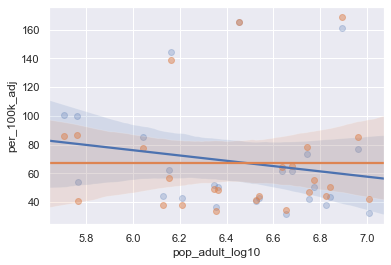

In [48]:
latest_totals_adj = (
    latest_totals
    .merge(
        adjustment_table
        [[
            "state",
            "pop_adult_log10",
            "adj"
        ]],
        how = "left"
    )
    .assign(
        per_100k_adj = lambda df: df["per_100k"] - df["adj"]
    )
)

(
    latest_totals_adj
    .pipe(lambda df: sns.regplot(
        y = df["per_100k"],
        x = df["pop_adult_log10"],
        truncate = False,
        scatter_kws = { "alpha": 0.25 }
    ))
)

(
    latest_totals_adj
    .pipe(lambda df: sns.regplot(
        y = df["per_100k_adj"],
        x = df["pop_adult_log10"],
        truncate = False,
        scatter_kws = { "alpha": 0.5 }
    ))
)

pass

Finally, we modify the bootstrap approach to take these adjustments into account. Specifically, for each sub-iteration, we pair a state with a random draw of one of the *normalized* rates, but then add the adjustment (increasing the effective rate for small states and decreasing it for large states) before calculating the product.

In [49]:
def gen_random_estimate_with_adj(populations, adj, rates):
    rand_rates = gen_random_items(rates, len(populations))
    return ((populations * (rand_rates + adj))).sum()

def bootstrap_with_adj(populations, adj, rates, n=1e4):
    return pd.Series(
        gen_random_estimate_with_adj(populations, adj, rates)
        for _ in range(int(n))
    )

This produces, as one would expect given the negative coefficient and the under-representation of large states in our sample, somewhat smaller estimates. Although, as noted above, unclear whether adjusting for population sizes produces a more accurate estimate, these results help provide an understanding of how the estimates might change *if* there were an underlying mechanism that decreased filing rates in larger states:

In [50]:
adjustment_table_not_counted = (
    adjustment_table
    .loc[lambda df: df["state"].isin(not_counted["state"])]
)

In [51]:
bootstrapped_adj_not_counted = bootstrap_with_adj(
    adjustment_table_not_counted["pop_adult"] / 1e5,
    adjustment_table_not_counted["adj"],
    latest_totals_adj["per_100k_adj"],
    1e4
)

In [52]:
pd.DataFrame({
    "Bootstrap": describe(bootstrapped_not_counted + known_total),
    "Monte Carlo": describe(mc_nbinom_not_counted + known_total),
    "Pop.-adj. Bootstrap": describe(bootstrapped_adj_not_counted + known_total),
})

,Bootstrap,Monte Carlo,Pop.-adj. Bootstrap
count,10000,10000,10000
mean,169894,169664,152585
std,18192,18666,17822
min,130881,117724,112751
2.5%,141745,137049,125252
25%,156176,156575,139456
50%,167242,168027,149849
75%,181235,181087,163292
97.5%,211340,209963,193819
max,255332,258759,238517


Here we compare the initial bootstrap estimates (in blue) to the population-adjusted ones (in orange):

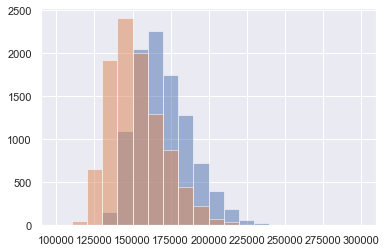

In [53]:
hist(bootstrapped_not_counted + known_total)
hist(bootstrapped_adj_not_counted + known_total)
pass

# Appendix B: Incorporating information about legal requirements

Various factors likely influence the number of guardianship cases filed in a given state. Some state laws make filing guardianship cases harder than others, for instance by requiring certain types of documentation. Others try to create alternatives to guardianship, such as through [Supported Decision-Making Agreements](https://www.americanbar.org/groups/law_aging/publications/bifocal/vol-41/volume-41-issue-1/where-states-stand-on-supported-decision-making/). BuzzFeed News collected data on four such aspects of guardianship law for each jurisdiction, and compared them to the observed filing rates:

- `sdma`: Did the state allow for Supported Decision-Making Agreements in 2019?
- `lra`: Did the state require judges to consider less restrictive alternatives to guardianship before granting a petition in 2019?
- `ex_parte`: Did the state allow for ex parte orders of guardianship in 2019?
- `documentation_required`: Did the state require documentation of incapacity to be submitted with the guardianship petition in 2019?

Although it would be reasonable to assume these laws have some effect, we saw no clear pattern we could confidently incorporate into our estimates, perhaps due to our small sample size or perhaps because other factors outweigh these.

In [54]:
regimes = (
    pd.read_csv("../data/raw/legal-regimes.csv")
    [[
        "state",
        "sdma",
        "lra",
        "ex_parte",
        "documentation_required",
    ]]
    .rename(columns = {"documentation_required": "docu_req"})
    .assign(
        num_constraints = lambda df: (
            df["sdma"] + df["lra"] + (df["ex_parte"] == 0) + df["docu_req"]
        ),
        has_constraint = lambda df: df["num_constraints"] > 0
    )
    .merge(
        latest_totals_adj
        [[
            "state",
            "per_100k",
        ]],
        how = "left",
    )
    .merge(
        populations
        [[
            "state",
            "pop_adult",
        ]],
        how = "left"
    )
    .assign(
        pop_adult_log10 = lambda df: df["pop_adult"].apply(np.log10),
        in_sample = lambda df: df["state"].isin(latest_totals["state"])
    )
)

regimes.sort_values("per_100k", ascending=False).dropna()

,state,sdma,lra,ex_parte,docu_req,num_constraints,has_constraint,per_100k,pop_adult,pop_adult_log10,in_sample
6,Connecticut,0,1,1,0,1,True,165.618513,2837847,6.452989,True
22,Michigan,0,0,1,0,0,False,161.355637,7842924,6.894478,True
27,Nebraska,0,1,1,0,1,True,144.617077,1458334,6.163857,True
45,Vermont,0,0,1,0,0,False,100.395307,509984,5.707557,True
8,District of Columbia,1,1,1,0,2,True,99.553136,577581,5.761613,True
29,New Hampshire,0,1,1,1,2,True,85.562330,1104458,6.043149,True
35,Ohio,0,0,1,0,0,False,76.730741,9111081,6.959570,True
21,Massachusetts,0,1,1,1,2,True,73.271076,5539703,6.743486,True
48,West Virginia,0,1,1,1,2,True,62.404892,1432580,6.156119,True
25,Missouri,0,1,0,0,2,True,61.298432,4766843,6.678231,True


Jurisdictions outside our sample were roughly equally likely (~80%) to exhibit at least one of these four constraints (either `sdma==1`, `lra==1`, `documentation_required==1`, or `ex_parte==0`):

In [55]:
(    
    regimes
    .groupby(["in_sample"])
    ["has_constraint"]
    .value_counts(normalize=False)
    .unstack()
    .assign(prop = lambda df: (df[True] / df.sum(axis = 1)).round(3))
)

has_constraint,False,True,prop
in_sample,,,
False,6,20,0.769
True,4,21,0.840


... and both had a median of one constraint, though out-of-sample jurisdictions had slightly more total constraints on average:

In [56]:
(    
    regimes
    .groupby(["in_sample"])
    .pipe(lambda grp: pd.DataFrame({
        "c_median": grp["num_constraints"].median(),
        "c_mean": grp["num_constraints"].mean().round(3),
    }))
)

,c_median,c_mean
in_sample,,
False,1.0,1.423
True,1.0,1.160


The number of constraints, however, does not seem to be clearly predictive of per-capita filing rates, especially given how few jurisdictions fall into most buckets:

In [57]:
(    
    regimes
    .groupby("num_constraints")
    ["per_100k"]
    .describe()
    .round(2)
)

,count,mean,std,min,25%,50%,75%,max
num_constraints,,,,,,,,
0,4.0,95.71,49.42,44.37,68.64,88.56,115.64,161.36
1,13.0,61.36,42.53,31.49,40.43,43.09,51.60,165.62
2,8.0,64.04,21.80,32.50,51.41,61.85,76.34,99.55
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


... and it is difficult to discern clear patterns from each individual constraint, in part because the comparisons each involve one very small grouping:

In [58]:
for col in [ "sdma", "lra", "ex_parte", "docu_req" ]:
    print(f"=== {col} ===")
    print(regimes.groupby(col)["per_100k"].describe().T.round(2))
    print("")

=== sdma ===
sdma        0      1
count   23.00   2.00
mean    66.93  76.76
std     39.84  32.24
min     31.49  53.96
25%     42.60  65.36
50%     50.22  76.76
75%     75.00  88.16
max    165.62  99.55

=== lra ===
lra         0       1
count    5.00   20.00
mean    85.19   63.34
std     48.84   36.04
min     43.09   31.49
25%     44.37   41.81
50%     76.73   50.91
75%    100.40   65.12
max    161.36  165.62

=== ex_parte ===
ex_parte      0       1
count      2.00   23.00
mean      52.19   69.06
std       12.87   40.14
min       43.09   31.49
25%       47.64   42.60
50%       52.19   51.60
75%       56.75   81.15
max       61.30  165.62

=== docu_req ===
docu_req       0      1
count      20.00   5.00
mean       69.77  59.50
std        42.21  21.53
min        31.49  32.50
25%        42.77  43.77
50%        50.91  62.40
75%        82.44  73.27
max       165.62  85.56



# Appendix C: Examining spatial correlation

Statisticians suggested that we also check for spatial correlation in our observations — i.e., do states near one another have a greater tendency to have similar rates?

To do so, we compare each state's filing rate to those of its neighbors (states that share a border or corner):

In [59]:
adjacencies = (
    # Data source: https://gist.github.com/rietta/4112447
    pd.read_csv("../data/raw/adjacent-states.csv")
    .assign(
        state = lambda df: df["state"].apply(states.lookup).astype(str),
        neighbor = lambda df: df["neighbor"].apply(states.lookup).astype(str),
    )
)    
adjacencies.head()

,state,neighbor
0,Alabama,Florida
1,Alabama,Georgia
2,Alabama,Mississippi
3,Alabama,Tennessee
4,Arkansas,Louisiana


In [60]:
def compare_neighbors(rates):
    return (
        rates
        [[
            "state",
            "per_100k",
        ]]
        .rename(columns = { "state": "neighbor" })
        .merge(
            adjacencies,
            on = "neighbor",
            how = "left",
        )
        .groupby("state")
        .pipe(lambda grp: pd.DataFrame({
            "per_100k_neighbor_mean": grp["per_100k"].mean(),
            "neighbors": grp["neighbor"].apply(set).apply(sorted),
        }))
        .reset_index()
        .pipe(lambda df: (
            rates
            [[
                "state",
                "per_100k",
            ]]
            .merge(
                df,
                how = "left",
                on = "state",
            )
        ))
        .dropna()
    )

In [61]:
neighbor_comparison = compare_neighbors(latest_totals)

neighbor_comparison.head()

,state,per_100k,per_100k_neighbor_mean,neighbors
0,Arizona,42.263156,36.870162,"[Colorado, New Mexico, Utah]"
1,Arkansas,50.223308,61.298432,[Missouri]
2,Colorado,31.494369,63.519803,"[Arizona, Kansas, Nebraska, New Mexico, Utah]"
3,Connecticut,165.618513,73.271076,[Massachusetts]
4,District of Columbia,99.553136,37.724706,[Virginia]


We see some correlation, but it does not reach the standard level of statistical significance — although, again, our sample size may simply be too small to detect it.

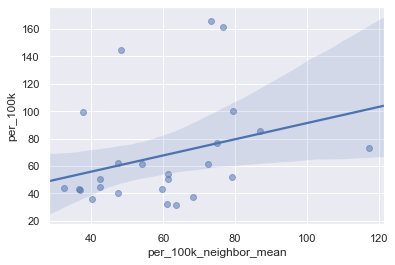

In [62]:
(
    neighbor_comparison
    .pipe(lambda df: sns.regplot(
        y = df["per_100k"],
        x = df["per_100k_neighbor_mean"],
        truncate = False,
        scatter_kws = { "alpha": 0.5 },
    ))
)
pass

In [63]:
(
    neighbor_comparison
    .pipe(lambda df: (
        sm.OLS(
            df["per_100k"],
            sm.add_constant(df["per_100k_neighbor_mean"]),
        )
     ))
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               per_100k   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.318
Date:                Thu, 30 Sep 2021   Prob (F-statistic):              0.142
Time:                        10:01:14   Log-Likelihood:                -125.22
No. Observations:                  25   AIC:                             254.4
Df Residuals:                      23   BIC:                             256.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     32.2875     24.465      1.320      0.200     -18.322      82.897
per_100k_neighbor_mean     0.5903      0.388      1.522      0.142      -0.212       1.392
==============================================================================
Omnibus:                       11.896   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.530
Skew:                           1.493   Prob(JB):                      0.00517
Kurtosis:                       4.093   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

---

---